Author: Martin Loza

Date: 23/12/31

In this workflow I want to calculate the average matrix for the MicroHi-C data from the 4DN portal
In previous test I failed to get the average on high resolution data as 10Kbs. I would like to optimize the workflow to be able to complete the task. 
One possible way is to perform the average on each chromosome. This should be OK, as we already discarted the intra-chromosomal interactions.



In [43]:
# Init libraries
import cooler
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import gc


scaler = StandardScaler()

# Global variables
data_dir = "/mnt/c/Users/Marti/Documents/Projects/HK_Interactions/Data/HiC/4DN_portal/raw/"
out_dir = "/mnt/c/Users/Marti/Documents/Projects/HK_Interactions/Data/HiC/4DN_portal/average/01_bedpe/"

# Local functions

# from Functions_Average import PreprocessPixels, GetAverageMatrix, GetResolutionsMcool

def GetResolutionsMcool(mcool_path):
    """
    Get the available resolutions from an mcool file.
    
    Parameters:
    - mcool_path: str, path to the mcool file
    
    Returns:
    - resolutions: list of int, available resolutions in the mcool file
    """
    # Open the mcool file
    with h5py.File(mcool_path, 'r') as tmp_mcool:
        # Get the available resolutions
        resolutions = tmp_mcool['resolutions'].keys()
        # Change the resolutions to a vector
        resolutions = [int(res) for res in resolutions]
        # Order the resolutions
        resolutions.sort()
    
    return resolutions

def SameResolutionMcools(mcools_path):
    """
    Compare the resolutions of multiple mcool files.
    
    Parameters:
    - mcool_files: list of str, paths to the mcool files
    
    Returns:
    - resolutions_equal: bool, True if all resolutions are equal, False otherwise
    """
    resolutions_list = []
    
    for mcool_file in mcools_path:
        resolutions = GetResolutionsMcool(mcool_file)
        resolutions_list.append(resolutions)
    
    resolutions_equal = all(resolutions_list[i] == resolutions_list[i+1] for i in range(len(resolutions_list)-1))
    
    return resolutions_equal

def ScaleByGroup(df, group_column):
    """
    Scale the 'log10_balanced' values in a DataFrame by group.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - group_column (str): The column name used for grouping.

    Returns:
    - scaled_matrix (pandas.DataFrame): The DataFrame with scaled 'log10_balanced' values.

    """
    # Obtain the unique values of the group column
    group_values = df[group_column].unique()

    # Create a list to store the scaled matrices
    scaled_matrices = []

    # Loop through each group value
    for value in group_values:
        # Filter the DataFrame by group value
        tmp_data = df[df[group_column] == value].copy()

        # Scale the log10_balanced values
        tmp_data['scaled'] = scaler.fit_transform(tmp_data['log10_balanced'].values.reshape(-1, 1))

        # Append the scaled matrix to the list
        scaled_matrices.append(tmp_data)

    # Concatenate the scaled matrices
    scaled_matrix = pd.concat(scaled_matrices)

    return scaled_matrix

def FilterIdNCells(df, n_cells=5, column='count', plot_histogram=True):
    """
    Filters the DataFrame based on the number of elements per ID and returns the filtered DataFrame.

    Parameters:
    - df: DataFrame
        The input DataFrame containing the data.
    - n_cells: int, optional (default=5)
        The number of cells required for an interaction ID to be included in the filtered DataFrame.
    - column: str, optional (default='count')
        The column in the DataFrame used for counting the number of elements per ID.
    - plot_histogram: bool, optional (default=True)
        Whether to plot a histogram of interaction IDs with less than n_cells elements.

    Returns:
    - df: DataFrame
        The filtered DataFrame containing only the interaction IDs that appear in n_cells cell types.
    """
    # count the number of elements per id
    tmp = df.groupby('id')[column].count()
    # ids of interaction appearing in n cell types
    ids = tmp[tmp == n_cells].index
    # filter the data
    df = df[df['id'].isin(ids)]
    
    if plot_histogram:
        # histogram of interaction in less than n cell types
        plt.hist(tmp[tmp < n_cells], bins=10)
        plt.title(f"Distribution of Interaction IDs with Less than {n_cells} Elements\nColumn: {column}")
        plt.xlabel("Number of Elements")
        plt.ylabel("Frequency")
        plt.show()
    
    return df

# Function to replace NaN values with a value outside the range of the data
def ReplaceNaNs(df, column='scaled', replace_with=-10):
    """
    Replaces NaN values in a specified column of a DataFrame with a specified value.
    
    Args:
        df (pandas.DataFrame): The DataFrame containing the column with NaN values.
        column (str): The name of the column to replace NaN values in. Default is 'scaled'.
        replace_with (float): The value to replace NaN values with. Default is -10.
        
    Returns:
        pandas.DataFrame: The DataFrame with NaN values replaced in the specified column.
    """
        
    #if the value is true, throw a warning and change the nan_value to something more appropriate
    if df[column].min() < replace_with:
        # Change the value based on the minimum value of the scaled data
        replace_with = round(df[column].min() - 1)  
        warnings.warn(f"The replace_with is not outside the range of the scaled data. Changing the value to: {nan_value}")
        
    # replace the NaN values with the nan_value
    df[column] = df[column].fillna(replace_with)
    
    return df

def PreprocessPixels(metadata, chromosomes, resolution, test=False):
    """
    Preprocesses the pixels of a matrix for a given cell type. Perform log10 transformation and scaling by chromosome.

    Args:
        metadata (DataFrame): The metadata containing information about the cell types and mcool file paths.
        chromosomes (list): The list of chromosomes to include in the analysis.
        resolution (int): The resolution of the mcool.

    Returns:
        DataFrame: The preprocessed and scaled matrix.

    """
    # List to store scaled matrices
    scaled_matrices = []

    if test:
        cell_index = [0]
    else:
        cell_index = list(range(len(metadata)))

    # Loop through each cell type, e.g. each row in the metadata
    for i in cell_index:
        # Get the current cell type
        cell_type = metadata['Biosource'][i]
        # Get the current mcool file path
        mcool_file = metadata['local_path'][i]
           
        # Load the mcool file
        cool_data = cooler.Cooler(mcool_file + "::resolutions/" + str(resolution))
            
        # Load the balanced matrix
        cool_matrix = cool_data.matrix(balance=True, as_pixels=True, join=True)[:]
        # Delete the cooler data to save memory
        del cool_data
        gc.collect()

        
        # Select pixels of chromosomes of interest
        cool_matrix = cool_matrix[cool_matrix['chrom1'].isin([chromosomes])].reset_index(drop=True)
        cool_matrix = cool_matrix[cool_matrix['chrom2'].isin([chromosomes])].reset_index(drop=True) 
            
        # remove inter-chromosomal interactions
        cool_matrix = cool_matrix[cool_matrix['chrom1'] == cool_matrix['chrom2']].reset_index(drop=True) 

        # Add a column with the cell type
        cool_matrix['cell_type'] = cell_type

        # Calculate the log10 of balanced counts
        cool_matrix['log10_balanced'] = cool_matrix.groupby('chrom1')['balanced'].transform(lambda x: np.log10(x))
            
        # Scale the log10 transformed values by chromosome using scale_by_group function
        scaled_matrix = ScaleByGroup(cool_matrix, 'chrom1')
        # Delete the cool_matrix to save memory
        del cool_matrix
        gc.collect()

        # Append the scaled matrix to the list
        scaled_matrices.append(scaled_matrix)
        # Delete the scaled_matrix to save memory
        del scaled_matrix
        gc.collect()


    # Concatenate the scaled matrices
    scaled_matrices = pd.concat(scaled_matrices)
        
    return scaled_matrices

def GetAverageMatrix(scaled_data, metadata,  plot_histogram=True, replaceNaN_with=-10, filter_nCells=6):

    # Let's add an interaction_id, then group by interaction (or loop by interaction) to average the scaled data.
    # This can be a bit time consuming for high resolution bins.
        
    # add interaction id
    scaled_data['id'] = scaled_data['chrom1'].astype(str) + '_' + scaled_data['start1'].astype(str) + '_' + scaled_data['chrom2'].astype(str) + '_' + scaled_data['start2'].astype(str)

    #Filter interactions that doesn't appear in all cell types using the local function
    scaled_data = FilterIdNCells(df = scaled_data, n_cells=filter_nCells, column='count', plot_histogram=plot_histogram)

    # Replace NaN values with a value outside the range of the data
    scaled_data = ReplaceNaNs(scaled_data, column='scaled', replace_with=replaceNaN_with)
    # short test to make sure everything is working
    test = scaled_data['scaled'].isna().sum()
    if test > 0:
        print(f"There are {test} NaN values in the scaled column after replacing them with an arbitrary value.")
        # stop the loop if there are still NaN values
        # break

    # Group by interaction id and average the scaled values
    mean_values = scaled_data.groupby('id')['scaled'].mean()
    # Convert the mean_values series to a dataframe and reset the index
    mean_values = mean_values.reset_index()
    # Rename the columns
    mean_values.columns = ['id', 'mean']

    # Create a new dataframe to store the mean values
    # we can filter the data for only one cell type and remove the unnecessary columns. Let's reuse the scaled_data dataframe
    data_mean = scaled_data[scaled_data['cell_type'] == metadata['Biosource'][0]]
    
    # select only the columns we need
    data_mean = data_mean[['id', 'chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']]

    # Merge the mean_values with the data_mean dataframe
    data_mean = data_mean.merge(mean_values, on='id', how='left')

    # Select the columns we need
    data_mean = data_mean[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'mean']]

    return data_mean
      

In [6]:
# Load the metadata. We need to skip the first row because it is a comment. 
# We use the first row as header
metadata = pd.read_csv(data_dir + "/metadata.tsv", sep="\t", header=0, skiprows=1)[:]
# Select the columns of interest
metadata = metadata[['File Accession', 'Biosource']]
# Remove the rows with NaN values
metadata = metadata.dropna()
# Add the file path to the metadata
metadata['local_path'] = data_dir + metadata['File Accession'] + ".mcool"

In [8]:
print(SameResolutionMcools(metadata['local_path']))
GetResolutionsMcool(metadata['local_path'][0])

True


[1000,
 2000,
 5000,
 10000,
 25000,
 50000,
 100000,
 250000,
 500000,
 1000000,
 2500000,
 5000000,
 10000000]

Now, we need to loop over the resolutions, scale them and average over cells.

In [51]:
# Define the chromosomes to analyse
# chromosomes = ['chr14']
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17','chr18','chr19','chr20','chr21','chr22','chrX']

# Define the resolutions to use
resolutions = GetResolutionsMcool(metadata['local_path'][0])

#test resolution
#arrange resolution from high to low
resolutions.sort(reverse=True)
resolutions = [1000000, 500000, 250000, 100000, 50000]
resolutions = [1000000]
# resolutions = [ 100000, 50000, 25000, 10000,  5000, 2000, 1000]
# resolutions = ['1000', '10000', '100000', '1000000', '2000', '25000', '250000', '2500000', '5000', '50000', '500000', '5000000']
resolutions

[1000000]

Let's try to further optimize the process by scaling and averaing by chromosome

In [ ]:
print(f"Available resolutions: {resolutions}")

# For each resolution, get the average matrix and save it to a bed file
for resolution in resolutions: 

    # If average matrix already exists, skip the resolution
    if os.path.exists(out_dir + f"average_matrix_{resolution}.bed"):
        print(f"Average matrix for resolution {resolution} already exists. Skipping...")
        continue

    print(f"Processing resolution: {resolution}")

    # Create a list to store the average matrices by chromosome 
    average_matrices = []

    # To optimize the process, let's try to do it within a loop by chromosome
    for chromosome in chromosomes:

        print(f"Processing chromosome: {chromosome}")
        
        print("Preprocessing pixels...")
        # Preprocess the pixels
        scaled_data = PreprocessPixels(metadata, chromosome, resolution, test=False)
        gc.collect()

        print("Getting average matrix by chromosome...")
        
        # Get the average matrix
        average_matrix = GetAverageMatrix(scaled_data, metadata, replaceNaN_with=-10, plot_histogram=False, filter_nCells=len(metadata))
        
        # Remove the scaled data to save memory
        # del scaled_data
        gc.collect()


        # Append the average matrix to the list
        average_matrices.append(average_matrix)
        
        # Save the average matrix to a bed file
        average_matrix.to_csv(out_dir + f"/tmp/average_matrix_{resolution}_{chromosome}.bed", sep='\t', index=False, header=False)


    ### TESTS plots

    # Reset the index of the scaled_matrix DataFrame
    scaled_matrix = scaled_data.reset_index(drop=True)

    # Remove empty categories in chrom1 column
    scaled_matrix['chrom1'] = scaled_matrix['chrom1'].cat.remove_unused_categories()

    # Plot the boxplots across cells by chromosomes
    plt.figure(figsize=(20, 5))
    sns.boxplot(data=scaled_matrix, x='chrom1', y='scaled', hue='cell_type', fliersize=0.5 )
    plt.title('Boxplot of Scaled Chromosomes')
    plt.xlabel('Chromosome')
    plt.ylabel('Scaled Values')
    plt.xticks(rotation=45)
    plt.legend(title='Cell Type')
    plt.show()

    # Plot the boxplots across cells by chromosomes
    # Remove empty categories in chrom1 column
    average_matrix['chrom1'] = average_matrix['chrom1'].cat.remove_unused_categories()
    plt.figure(figsize=(20, 5))
    sns.boxplot(data=average_matrix, x='chrom1', y='mean', fliersize=0.5 )
    plt.title('Average interaction. Resolution: ' + str(resolution))
    plt.xlabel('Chromosome')
    plt.ylabel('Mean Values')
    plt.xticks(rotation=45)
    plt.show()

    # Concatenate the average matrices
    average_matrix = pd.concat(average_matrices)
    
    # Save the average matrix to a bed file
    average_matrix.to_csv(out_dir + f"average_matrix_{resolution}.bed", sep='\t', index=False, header=False)
    
    # Remove the average matrices to save memory
    del average_matrices
    gc.collect()

In [13]:
print(f"Available resolutions: {resolutions}")

# For each resolution, get the average matrix and save it to a bed file
for resolution in resolutions: 

    # If average matrix already exists, skip the resolution
    if os.path.exists(out_dir + f"average_matrix_{resolution}.bed"):
        print(f"Average matrix for resolution {resolution} already exists. Skipping...")
        continue

    print(f"Processing resolution: {resolution}")

    # Create a list to store the average matrices by chromosome 
    average_matrices = []

    # To optimize the process, let's try to do it within a loop by chromosome
    for chromosome in chromosomes:

        print(f"Processing chromosome: {chromosome}")
        
        print("Preprocessing pixels...")
        # Preprocess the pixels
        scaled_data = PreprocessPixels(metadata, chromosome, resolution, test=False)
        gc.collect()


Available resolutions: [1000000]
Processing resolution: 1000000
Processing chromosome: chr14
Preprocessing pixels...


/tmp/ipykernel_5252/1799706114.py:207: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cool_matrix['log10_balanced'] = cool_matrix.groupby('chrom1')['balanced'].transform(lambda x: np.log10(x))
/tmp/ipykernel_5252/1799706114.py:207: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cool_matrix['log10_balanced'] = cool_matrix.groupby('chrom1')['balanced'].transform(lambda x: np.log10(x))
/tmp/ipykernel_5252/1799706114.py:207: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt th

In [20]:
scaled_data['scaled'].isna().sum()

1625

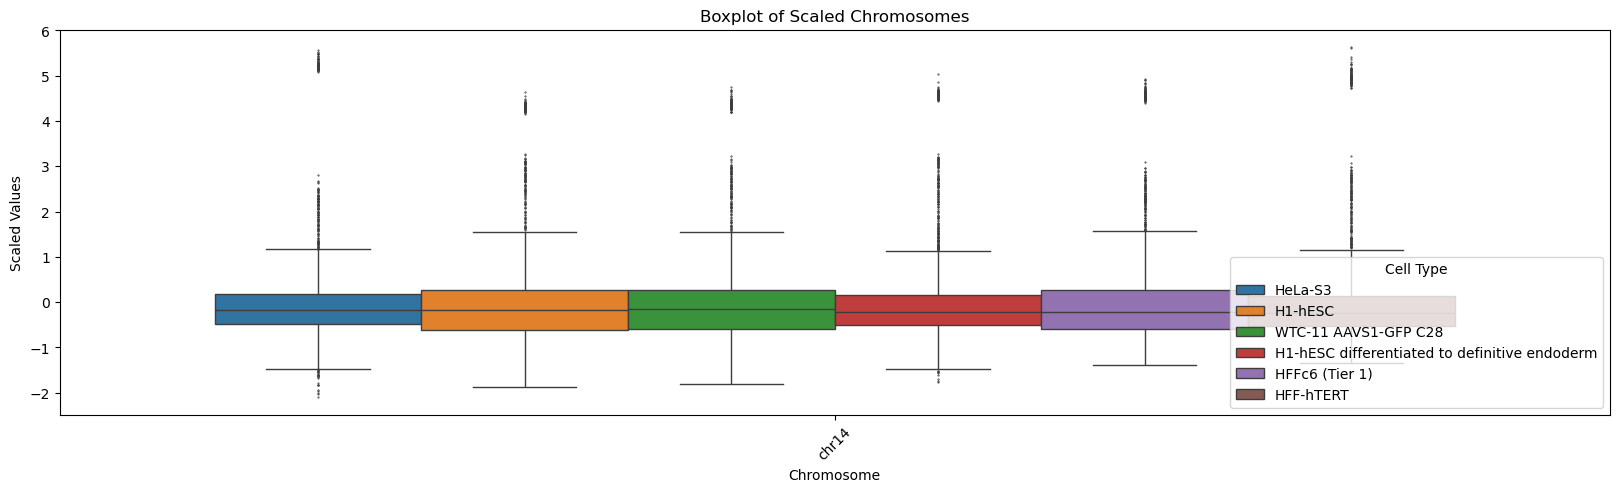

In [26]:


# Reset the index of the scaled_matrix DataFrame
scaled_matrix = scaled_data.reset_index(drop=True)

# Remove empty categories in chrom1 column
scaled_matrix['chrom1'] = scaled_matrix['chrom1'].cat.remove_unused_categories()

# Plot the boxplots across cells by chromosomes
plt.figure(figsize=(20, 5))
sns.boxplot(data=scaled_matrix, x='chrom1', y='scaled', hue='cell_type', fliersize=0.5 )
plt.title('Boxplot of Scaled Chromosomes')
plt.xlabel('Chromosome')
plt.ylabel('Scaled Values')
plt.xticks(rotation=45)
plt.legend(title='Cell Type')
plt.show()


#

Getting average matrix by chromosome...


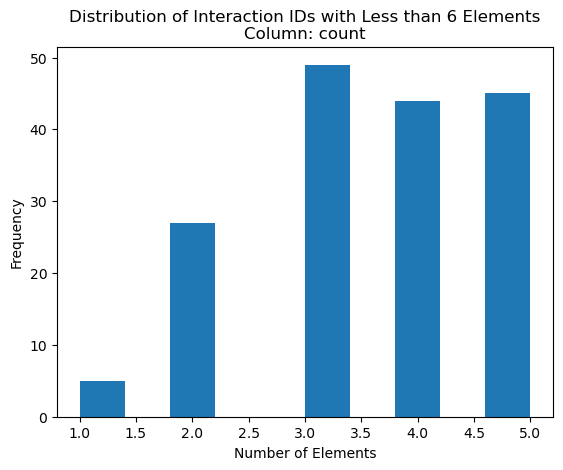

/tmp/ipykernel_5252/1799706114.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna(replace_with)


In [38]:

print("Getting average matrix by chromosome...")
        
# Filter the data by chromosome
# scaled_data = scaled_data[scaled_data['chrom1'] == chromosome]
        
# Get the average matrix
average_matrix = GetAverageMatrix(scaled_data, metadata, replaceNaN_with=-10, plot_histogram=True, filter_nCells=len(metadata))
        
# Remove the scaled data to save memory
# del scaled_data
gc.collect()

# Append the average matrix to the list
average_matrices.append(average_matrix)
        
# Save the average matrix to a bed file
# average_matrix.to_csv(out_dir + f"/tmp/average_matrix_{resolution}_{chromosome}.bed", sep='\t', index=False, header=False)


In [31]:
scaled_data.max()

chrom1                                    chr14
start1                                106000000
end1                                  107000000
chrom2                                    chr14
start2                                106000000
end2                                  107000000
count                                   2931262
balanced                               3.421675
cell_type                  WTC-11 AAVS1-GFP C28
log10_balanced                         0.534239
scaled                                 5.631702
id                chr14_99000000_chr14_99000000
dtype: object

In [30]:
average_matrix.max()

chrom1        chr14
start1    106000000
end1      107000000
chrom2        chr14
start2    106000000
end2      107000000
mean       4.997573
dtype: object

In [37]:
#get index of nan values from scaled_data
index = scaled_data[scaled_data['scaled'].isna()].index
#select rows from average_matrix with the index
# tmp = average_matrix.loc[index]
3925*6
24157-23550

607

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


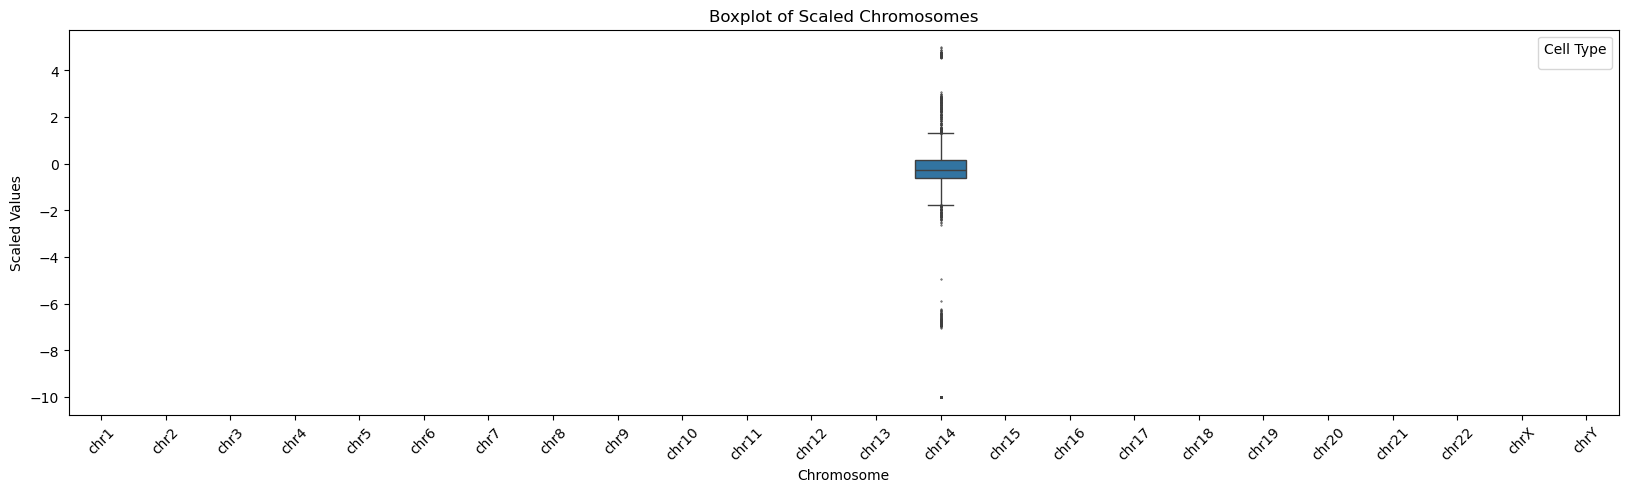

In [39]:
# Plot the boxplots across cells by chromosomes
plt.figure(figsize=(20, 5))
sns.boxplot(data=average_matrix, x='chrom1', y='mean', fliersize=0.5 )
plt.title('Boxplot of Scaled Chromosomes')
plt.xlabel('Chromosome')
plt.ylabel('Scaled Values')
plt.xticks(rotation=45)
plt.legend(title='Cell Type')
plt.show()

In [ ]:

# Concatenate the average matrices
average_matrix = pd.concat(average_matrices)
    
# Save the average matrix to a bed file
average_matrix.to_csv(out_dir + f"average_matrix_{resolution}.bed", sep='\t', index=False, header=False)
    
# Remove the average matrices to save memory
del average_matrices
gc.collect()

In [ ]:

        print("Getting average matrix by chromosome...")
        
        # # Filter the data by chromosome
        # scaled_data = scaled_data[scaled_data['chrom1'] == chromosome]
        
        # Get the average matrix
        average_matrix = GetAverageMatrix(scaled_data, metadata, replaceNaN_with=-10, plot_histogram=False, filter_nCells=len(metadata))
        
        # Remove the scaled data to save memory
        # del scaled_data
        gc.collect()

        # Append the average matrix to the list
        average_matrices.append(average_matrix)
        
        # Save the average matrix to a bed file
        average_matrix.to_csv(out_dir + f"/tmp/average_matrix_{resolution}_{chromosome}.bed", sep='\t', index=False, header=False)

    # Concatenate the average matrices
    average_matrix = pd.concat(average_matrices)
    
    # Save the average matrix to a bed file
    average_matrix.to_csv(out_dir + f"average_matrix_{resolution}.bed", sep='\t', index=False, header=False)
    
    # Remove the average matrices to save memory
    del average_matrices
    gc.collect()

In [18]:
#load the old average matrix to compare
old_average_matrix = pd.read_csv(out_dir + "average_matrix_10000000.bed", sep="\t", header=None)

In [31]:
print(sum(old_average_matrix[6].values == average_matrix['mean'].values))
print(len(old_average_matrix))
#number of rows in the old average matrix
# len(old_average_matrix)
# len(average_matrix)



2000
2601


I obtained some unmatched values, let's explore them

In [30]:
# Get the index of the rows that are different
index = np.where(old_average_matrix[6].values != average_matrix['mean'].values)[0]

They look normal to me.. maybe just small decimals

In [34]:
# Calculate the abs difference between the old and new average matrices
abs_diff = abs(old_average_matrix[6].values - average_matrix['mean'].values)
abs_diff.max()

8.881784197001252e-16

OK, the difference is reeeeealy small. Let's try to add this code to a .py script!


I coded and tested in a super computer. I want to compare their results.

In [35]:
#load the old average matrix to compare
old_average_matrix = pd.read_csv(out_dir + "average_matrix_10000000.bed", sep="\t", header=None)

OSError: [Errno 19] No such device: '/mnt/d/Projects/HK_Interactions/Data/HiC/4DN_portal/average/average_matrix_10000000.bed'